# Data binner
#### For FERMI data from Oct/Nov 2017 at DiProI beamline

## Info

This script works on the HDF5 files created by the Data collector (16_data_collection.ipynb) that end on '_col.h5' and are located in the 'combined' folder of each run.

The script has two main functionailities:
1. Apply filters to the data on a shot-to-shot basis with respect to e.g. incident intensity, photon energy bandwidth, ...
2. Bin the data along incident phton energy and pump-probe delay. For the incident photon energy binnig is performed based on the actual central photon energy of each shot.

Uses:
- /src/data_tools_v2.py
- /src/fit_tools.py
- /src/AnalysisTools.py

-----------------------
Created by Simon Schreck (simon.schreck@fysik.su.se) in Dec 2017 - Jan 2018 - with some parts beeing courtousy of Fivos Perakis.

Last updated: July 2020, by Jerry LaRue (larue@chapman.edu)

# Load Packages

In [1]:
#####################
### Load Packages ###
#####################

import numpy as np
from pandas import DataFrame as df
import math
from matplotlib import pyplot as plt
import h5py
import sys
import time
import scipy.stats
import os.path
from importlib import reload
import ipywidgets as widgets
from ipywidgets import Button, Layout

sys.path.insert(0, '../src/')

import AnalysisTools as at

import data_tools_v2
reload(data_tools_v2)
import data_tools_v2 as dt

import fit_tools
reload(fit_tools)
from fit_tools import *

# Parameters

In [12]:
####################
### Data to Load ###
####################

# Data to load
load_fel = True
load_xas = True
load_xes = False
load_delay = True
load_laser = True
load_ms = False

###############
### Filters ###
###############

# Incident intensity
filter_fel_i0  = True 
fel_i0_thr_low = 5e4
fel_i0_thr_hi  = np.inf

# Incident photon energy bandwidth
filter_fel_width  = True
fel_width_thr_low = 0
fel_width_thr_hi  = 0.8

# FEL intensity
filter_xas_int  = True
xas_int_thr_low = 1000
xas_int_thr_hi  = np.inf

# LASER intensity
filter_laser_int  = True
laser_int_thr_low = 680
laser_int_thr_hi  = 750

##################
### Histograms ###
##################

show_histograms = False
n_bins = 50

###########
### XAS ###
###########

# Define which data are used for the XAS intensity
# Possible values:
# 'xas_img_int'    - Integrated intensity of the XAS image as calculated in data collection
# 'xas_daq_int'    - Integrated intensity of the XAS image as saved by DiProI DAQ
xas_source = 'xas_img_int'

# Energy Bins
xas_bins_type  = 'auto' # 'auto' or 'manual'
# If xas_bins_type is 'auto' use:
xas_bins_width = 0.05
xas_bins_offset = 0
# If xas_bins_type is 'manual' use:
# xas_bins_edges_man = np.array([281.6, 282.0, 282.4, 282.8, 283.2, 283.6, 284.0, 284.4, 284.8, 285.2, 285.6, 286.0, 286.4])
xas_bins_edges_man = np.array([280, 300])

###########
### XES ###
###########

# Define which data are used for the XAS intensity
# Possible values:
# 'xes_img_int'    - Integrated intensity of the XES image as calculated in data collection
# 'xes_daq_int'    - Integrated intensity of the XES image as saved by DiProI DAQ
xes_source = 'xes_img_int'

# Should the XES spectra be binned? True/False
bins_xes_specs = False

# XES emission energy rebinning (1 pixel ~ 60 meV) 
xes_reduction = 5 # 5 --> ~300 meV emission energy steps

# Provide filenames of dispersion of XES detector 
def getDisp(BT) :
    if BT == 1 :
        xes_disp = 'XAS021_disp.h5'
    elif BT == 2 :
        xes_disp = 'XAS035_disp.h5'
    else :
        raise NameError('BT mus be 1 or 2')
    return xes_disp

# BT 2
#xes_curv_file = 'XES001_NoPump_curv.h5'
# BT 1
xes_curv_file = 'XAS002_curv.h5'

#############
### Delay ###
#############

delay_bins_type   = 'manual' # 'auto' or 'manual'
# If delay_bin_type is 'auto' the delay values that were set during data aquisition are used as bin center

# If delay_bin_type is 'manual' define unit and bin EDGES (!!!) here:
delay_bins_unit   = 'ps'     # 'mm' or 'ps'

delay_edges = [-1]
start = -0.1
delta = .05
end = 20
#delta = 2
i = 0
while start + i * delta <= end :
    delay_edges.append(start + i * delta)
    i+=1
delay_edges = np.array(delay_edges)
# delay_edges = np.array((-10,10))

################
### Beamtime ###
################

BT = 2 # 1: 1st beamtime, 2: 2nd beamtime

#################
### Data Path ###
#################

if BT == 1 :
    data_path = 'D:/FERMI 2017 1/'
else:
    data_path = 'D:/FERMI 2017 2/'

##############
### Run(s) ###
##############

run_type = 'XAS'

runs = [14]

# Load Data

In [13]:
#################
### Functions ###
#################

def FilterMassSpec(counts,tof,mask) :
    
    counts_good = list()
    tof_good = list()

    for idx, val in enumerate(mask) :
        if mask[idx] :
            imin = sum(counts[:idx])
            imax = sum(counts[:idx+1])
            counts_good.append(counts[idx])
            tof_good.extend(tof[imin:imax])
    counts_good = np.array(counts_good)
    tof_good = np.array(tof_good)
    
    return counts_good,tof_good

def getTimeZero(runs, run_type, bt) :
    
    if bt == 2 :
        if (runs[0] in np.arange(0, 23+1)) and (run_type == 'XAS') :
            TimeZero = 141.654
        elif (runs[0] in [27, 28, 29]) and (run_type == 'XAS') :
            TimeZero = 141.530
        else :
            TimeZero = 141.654
    if bt == 1 :
        TimeZero = 136.376

    return TimeZero

############################
### Getting Things Ready ###
############################

%matplotlib inline

# Ignore Runtime Warnings for divide and invalid values
np.seterr(divide='ignore', invalid='ignore')

# Check that data path exists
if not os.path.exists(data_path) :
    raise NameError('Check data_path! It does not exist!')

# Check that all runs exist
i = 0
while i < len(runs) :
    # Create the path to the run folder
    run_path = dt.do_runpath(runs[i], run_type, BT, data_path)
    
    if not os.path.exists(run_path) :
        print('Run %d does not exist! Skipping this run!'%runs[i])
        runs = np.delete(runs, i)
    else :
        i = i + 1
        
print('Loading runs:')
print(runs)

# Start timer
t = time.time()

# Get TimeZero
TimeZero = getTimeZero(runs, run_type, BT)

# Define empty arrays to load data in
fel_bunchid_all   = []
fel_i0_all        = []
fel_center_all    = []
fel_width_all     = []
xas_int_all       = []
xes_int_all       = []
xes_spec_all      = []
delay_all         = []
laser_int_all     = []
ms_counts_all     = []
ms_tof_all        = []

#################
### Load Data ###
#################

# Loop over runs to load the data
for run in runs :
    # Create the path to the RUN folder
    run_path = dt.do_runpath(run, run_type, BT, data_path)
    print('\n---Messages, Run %d---'%run)
    
    # Path to data in this folder
    load_path = run_path+'/combined/'
    
    # Get file names of 'collected' files
    tmp,file_names = dt.discover_files(load_path)
    
    # Check for data :
    for file in file_names:
        
        fh5 = h5py.File(load_path+file, 'r')
        
        if load_fel :
            try :
                fh5['/bunch_id'][()]
                fh5['/FEL/i0'][()]
                fh5['/FEL/Gauss_centers'][()]
                fh5['/FEL/Gauss_widths'][()]
            except:
                load_fel = False
                load_xas = False
                load_xes = False
                print('FEL data is missing and will not be loaded.')
        
        if load_xas :
            try :
                if xas_source == 'xas_img_int' :
                    # Use integrated image intensity
                    fh5['/XAS/xas_tfy'][()]
                elif xas_source == 'xas_daq_int' :
                    # Use integrated intensity provided by daq
                    fh5['/XAS/xas_int'][()]
            except :
                load_xas = False
                print('XAS data is missing and will not be loaded.')
        
        if load_xes :
            try :
                if xes_source == 'xes_img_int' :
                    # Use integrated image intensity
                    fh5['/XES/xes_pfy'][()]
                elif xes_source == 'xes_daq_int' :
                    # Use integrated intensity provided by daq
                    fh5['/XES/xes_int'][()]
                fh5['/XES/xes_spec'][()]
            except :
                load_xes = False
                print('XES data is missing and will not be loaded.')
        
        if load_delay :
            try :
                fh5['/LASER/delay_pos'][()]
            except:
                load_delay = False
                print('Delay data is missing and will not be loaded.')
        
        if load_laser :
            try:
                fh5['LASER/laser_int'][()]
            except:
                load_laser = False
                print('Laser data is missing and will not be loaded.')

            if load_ms :
                try :
                    fh5['/MASSSPEC/counts'][()]
                    fh5['/MASSSPEC/tof'][()]
                except :
                    load_ms = False
                    print('Mass spec data is missing and will not be loaded.')
    
    # Loop over collected files
    for file in file_names:
        
        fh5 = h5py.File(load_path+file, 'r')
        
        if load_fel :
            # Bunch ID
            fel_bunchid = fh5['/bunch_id'][()]
            fel_bunchid_all.extend(fel_bunchid)
            
            #fel_i0
            fel_i0 = fh5['/FEL/i0'][()]
            fel_i0_all.extend(fel_i0)

            # Gauss center
            fel_center = fh5['/FEL/Gauss_centers'][()]
            fel_center_all.extend(fel_center)

            # Gauss widths
            fel_width = fh5['/FEL/Gauss_widths'][()]
            fel_width_all.extend(fel_width)
        
        if load_xas :
            if xas_source == 'xas_img_int' :
                # Use integrated image intensity
                xas_int = fh5['/XAS/xas_tfy'][()]
                xas_int_all.extend(xas_int)
            elif xas_source == 'xas_daq_int' :
                # Use integrated intensity provided by daq
                xas_int = fh5['/XAS/xas_int'][()]
                xas_int_all.extend(xas_int)        
            else :
                raise NameError('XAS_source %s is not a valid source!'%XAS_source)
        
        if load_xes :
            if xes_source == 'xes_img_int' :
                # Use integrated image intensity
                xes_int = fh5['/XES/xes_pfy'][()]
                xes_int_all.extend(xas_int)
            elif xes_source == 'xes_daq_int' :
                # Use integrated intensity provided by daq
                xes_int = fh5['/XES/xes_int'][()]
                xes_int_all.extend(xas_int)            
            else :
                raise NameError('XES_source %s is not a valid source!'%XES_source)
            xes_spec = fh5['/XES/xes_spec'][()]
            xes_spec_all.extend(xes_spec)

        # Delay
        if load_delay :
            delay_pos = fh5['/LASER/delay_pos'][()]
            delay_all.extend(delay_pos)
        
        # Laser
        if load_laser :
            laser_int = fh5['LASER/laser_int'][()]
            laser_int_all.extend(laser_int)
        
        # MS counts
        if load_ms :
            ms_counts = fh5['/MASSSPEC/counts'][()]
            ms_counts_all.extend(ms_counts)
            ms_tof = fh5['/MASSSPEC/tof'][()]
            ms_tof_all.extend(ms_tof)

# Convert data to numpy arrays
if load_fel :
    fel_bunchid_all     = np.array(fel_bunchid_all)
    fel_i0_all          = np.array(fel_i0_all)
    fel_center_all      = np.array(fel_center_all)
    fel_width_all       = np.array(fel_width_all)
if load_xas :
    xas_int_all         = np.array(xas_int_all)
if load_xes :
    xes_int_all         = np.array(xes_int_all)
    xes_spec_all        = np.array(xes_spec_all)
if load_delay :
    delay_all           = np.array(delay_all)
if load_laser :
    laser_int_all       = np.array(laser_int_all)
if load_ms :
    ms_counts_all       = np.array(ms_counts_all)
    ms_tof_all          = np.array(ms_tof_all)

# Take out all shots wehere FEL spectrum fit failed, i.e. where fit parameters are NaN (to not have runtime warning later)
if load_fel :
    nan_mask            = ~np.isnan(fel_width_all)
    fel_bunchid_all     = fel_bunchid_all[nan_mask]
    fel_i0_all          = fel_i0_all[nan_mask]
    fel_center_all      = fel_center_all[nan_mask]
    fel_width_all       = fel_width_all[nan_mask]
if load_xas :
    xas_int_all         = xas_int_all[nan_mask]
if load_xes :
    xes_int_all         = xes_int_all[nan_mask]
    xes_spec_length     = len(xes_spec_all)/len(fel_bunchid_all)
    nan_mask_xes_spec   = np.repeat(nan_mask, xes_spec_length)
    xes_spec_all        = xes_spec_all[nan_mask_xes_spec]
if load_delay :
    delay_all           = delay_all[nan_mask]
if load_laser :
    laser_int_all       = laser_int_all[nan_mask]
if load_ms :
    ms_counts_all,ms_tof_all = FilterMassSpec(ms_counts_all,ms_tof_all,nan_mask)

# Convert delays to fs
delay_all = dt.mm2fs(delay_all - TimeZero)

###################
### Create Bins ###
###################

if load_xas :
    if xas_bins_type == 'auto' :
        xas_bins_min = np.floor(np.min(fel_center_all)/xas_bins_width)*xas_bins_width
        xas_bins_max = np.ceil(np.max(fel_center_all)/xas_bins_width)*xas_bins_width
        xas_bins_min = round(xas_bins_min-xas_bins_width/2,1)
        xas_bins_max = round(xas_bins_max+xas_bins_width/2,1)
        bins_num = (xas_bins_max - xas_bins_min) / xas_bins_width
        xas_bins = []
        xas_bins_edges = [xas_bins_min+xas_bins_offset]
        i = 0
        while i < bins_num :
            xas_bins = np.append(xas_bins,xas_bins_min+(1/2+i)*xas_bins_width+xas_bins_offset)
            xas_bins_edges = np.append(xas_bins_edges,xas_bins_min+(1+i)*xas_bins_width+xas_bins_offset)
            i += 1
    elif xas_bins_type == 'manual' :
        xas_bins_edges = np.array(xas_bins_edges_man, dtype=float)
        xas_bins = (xas_bins_edges[1:] + xas_bins_edges[:-1]) / 2
    else :
        raise NameError('xas_bins_type must be auto or manual')

if load_delay :
    if delay_bins_type == 'auto' :
        delay_bins_mm, n_shots_delay = np.unique(delay_pos_good, return_counts=True)
        if not len(delay_bins_mm) == 1 :
            delay_bins_edges = (delay_bins_mm[1:] + delay_bins_mm[:-1]) / 2
            delay_bins_edges = np.insert(delay_bins_edges, 0, delay_bins_mm[0] - 0.5*(delay_bins_mm[1]-delay_bins_mm[0]))
            delay_bins_edges = np.append(delay_bins_edges, delay_bins_mm[-1] + 0.5*(delay_bins_mm[-1]-delay_bins_mm[-2])) 
        else :
            delay_bins_edges = np.array([delay_bins_mm[0] - 200, delay_bins_mm[0] + 200])
        delay_bins       = dt.mm2fs(delay_bins_mm - TimeZero)
        delay_bins_edges = dt.mm2fs(delay_bins_edges - TimeZero)

    elif delay_bins_type == 'manual' :
        delay_bins_edges = delay_edges
        if delay_bins_unit == 'mm' :
            delay_bins_edges = dt.mm2fs(delay_bins_edges - TimeZero)
        elif delay_bins_unit == 'ps' :
            delay_bins_edges = delay_bins_edges*1000
        delay_bins_edges = np.array(delay_bins_edges)
        delay_bins       = (delay_bins_edges[1:] + delay_bins_edges[:-1]) / 2

####################
### Filter Data ####
####################

print('\n---Messages, all runs---')
print('\nFiltering...')
# Build the filter matrix
filter_matrix = []

# Filter on delay
if load_delay :
    print('... on delay range (%2.1e, %2.1e)'%(min(delay_bins_edges), max(delay_bins_edges)))
    filter_matrix.append(delay_all>=min(delay_bins_edges))
    filter_matrix.append(delay_all<=max(delay_bins_edges))
    filter_delay = np.all((filter_matrix[-1],filter_matrix[-2]), axis=0)
    print('      '+str(len(filter_delay) - sum(filter_delay))+' shots outside bounds')

# Filter on fel i0
if load_fel and filter_fel_i0 :
    print('... on FEL i0 (%2.1e, %2.1e)'%(fel_i0_thr_low, fel_i0_thr_hi))
    filter_matrix.append(fel_i0_all>=fel_i0_thr_low)
    filter_matrix.append(fel_i0_all<=fel_i0_thr_hi)
    filter_matrix_fel_i0 = np.all((filter_matrix[-1],filter_matrix[-2]), axis=0)
    print('      '+str(len(filter_matrix_fel_i0) - sum(filter_matrix_fel_i0))+' shots outside bounds')

# Filter on FEL bandwith
if load_fel and filter_fel_width :
    print('... on FEL bandwidth (%3.2f, %3.2f)' %(fel_width_thr_low, fel_width_thr_hi))
    filter_matrix.append(fel_width_all>=fel_width_thr_low)
    filter_matrix.append(fel_width_all<=fel_width_thr_hi)
    filter_matrix_fel_width = np.all((filter_matrix[-1],filter_matrix[-2]), axis=0)
    print('      '+str(len(filter_matrix_fel_width) - sum(filter_matrix_fel_width))+' shots outside bounds')
    
# Filter on FEL center energy
if load_fel :
    print('... on FEL range (%3.2f, %3.2f)' %(min(xas_bins_edges), max(xas_bins_edges)))
    filter_matrix.append(fel_center_all>=min(xas_bins_edges))
    filter_matrix.append(fel_center_all<=max(xas_bins_edges))
    filter_matrix_fel_center = np.all((filter_matrix[-1],filter_matrix[-2]), axis=0)
    print('      '+str(len(filter_matrix_fel_center) - sum(filter_matrix_fel_center))+' shots outside bounds')
    
# Filter on XAS intensity
if load_xas and filter_xas_int :
    print('... on XAS intensity (%3.2f, %3.2f)' %(xas_int_thr_low, xas_int_thr_hi))
    filter_matrix.append(xas_int_all>=xas_int_thr_low)
    filter_matrix.append(xas_int_all<=xas_int_thr_hi)
    filter_matrix_xas_int = np.all((filter_matrix[-1],filter_matrix[-2]), axis=0)
    print('      '+str(len(filter_matrix_xas_int) - sum(filter_matrix_xas_int))+' shots outside bounds')
    
# Filter on laser intensity
if load_laser and filter_laser_int :
    print('... on LASER intensity (%3.2f, %3.2f)' %(laser_int_thr_low, laser_int_thr_hi))
    filter_matrix.append(laser_int_all>=laser_int_thr_low)
    filter_matrix.append(laser_int_all<=laser_int_thr_hi)
    filter_matrix_laser_int = np.all((filter_matrix[-1],filter_matrix[-2]), axis=0)
    print('      '+str(len(filter_matrix_laser_int) - sum(filter_matrix_laser_int))+' shots outside bounds')
    
good_mask = np.all(filter_matrix, axis=0)

# Apply the filter
if load_fel :
    fel_bunchid_good      = fel_bunchid_all[good_mask]
    fel_i0_good           = fel_i0_all[good_mask]
    fel_center_good       = fel_center_all[good_mask]
    fel_width_good        = fel_width_all[good_mask]
if load_xas :
    xas_int_good          = xas_int_all[good_mask]
if load_xes :
    xes_int_good          = xes_int_all[good_mask]
    good_mask_xes_spec    = np.repeat(good_mask, xes_spec_length)
    xes_spec_good         = xes_spec_all[good_mask_xes_spec]
if load_delay :
    delay_good            = delay_all[good_mask]
if load_laser :
    laser_int_good        = laser_int_all[good_mask]
if load_ms :
    ms_counts_good,ms_tof_good = FilterMassSpec(ms_counts_all,ms_tof_all,good_mask)

#######################
### Display Results ###
#######################

print('\nTotal number of ALL shots: %d' %(len(fel_bunchid_all)))
print('Filtered out %3.2f percent of all the shots' %(100*(len(fel_bunchid_all)-len(fel_bunchid_good))/len(fel_bunchid_all)))
print('Total number of GOOD shots: %d' %(len(fel_bunchid_good)))

print('\nDelay bin centers in fs:')
print(delay_bins*1e-3)

print('\nPhoton energy bin centers in eV:')
print(xas_bins)

if show_histograms :
    plt.figure(figsize = [15, 10])
    
    if load_fel :
        # fel i0
        plt.subplot(331)
        fel_i0_bins = np.arange(np.min(fel_i0_all), np.max(fel_i0_all), (np.max(fel_i0_all) - np.min(fel_i0_all)) / n_bins)
        plt.hist(fel_i0_all, bins = fel_i0_bins, label = 'All shots') 
        plt.hist(fel_i0_good, bins = fel_i0_bins, label = 'Good shots')
        plt.ylabel('Number of Shots')
        plt.xlabel('I0 (arb. u.)')
        #plt.title('Incident intensity fel_i0')
        plt.legend(loc = 0, fontsize = 9)

        # fel centers
        plt.subplot(332)
        fel_center_bins = np.arange(np.min(fel_center_all), np.max(fel_center_all), (np.max(fel_center_all) - np.min(fel_center_all)) / n_bins)
        plt.hist(fel_center_all, bins = fel_center_bins, label = 'All shots') 
        plt.hist(fel_center_good, bins = fel_center_bins, label = 'Good shots')
        plt.ylabel('Number of Shots')
        plt.xlabel('Gauss Center (eV)')
        #plt.title('Incident photon energy fel_centers')
        plt.legend(loc = 0, fontsize = 9)

        # fel widths
        plt.subplot(333)
        fel_width_bins = np.arange(0, 1.5, 1.5/n_bins)
        plt.hist(fel_width_all, bins = fel_width_bins, label = 'All shots') 
        plt.hist(fel_width_good, bins = fel_width_bins, label = 'Good shots')
        plt.ylabel('Number of Shots')
        plt.xlabel('Gauss Width (eV)')
        #plt.title('Incident bandwidth fel_widths')
        plt.xlim([0, 1.5])
        plt.legend(loc = 0, fontsize = 9)
    
    if load_xas :
        # xas intensity
        plt.subplot(334)
        xas_int_bins = np.arange(np.min(xas_int_all), np.max(xas_int_all), (np.max(xas_int_all) - np.min(xas_int_all)) / n_bins)
        plt.hist(xas_int_all, bins = xas_int_bins, label = 'All shots') 
        plt.hist(xas_int_good, bins = xas_int_bins, label = 'Good shots')
        plt.ylabel('Number of Shots')
        plt.xlabel('XAS intensity (arb. u.)')
        #plt.title('XAS intensity')
        plt.legend(loc = 0, fontsize = 9)
    
    if load_delay :
        # delay values
        plt.subplot(335)
        delay_all_bins = np.arange((int(np.min(delay_all)/n_bins)-1)*n_bins,int(np.max(delay_all)/n_bins)*n_bins,n_bins)
        plt.hist(delay_all, bins = delay_all_bins, label = 'All shots')
        plt.ylabel('Number of shots')
        plt.xlabel('Delay intensity')
        #plt.title('Delay intensity')
        plt.legend(loc = 0, fontsize = 9)
    
    if load_laser :
        # laser intensity
        plt.subplot(336)
        laser_int_bins = np.arange(np.nanmin(laser_int_all), np.nanmax(laser_int_all), (np.nanmax(laser_int_all) - np.nanmin(laser_int_all)) / n_bins)
        plt.hist(laser_int_all, bins = laser_int_bins, label = 'All shots')
        plt.hist(laser_int_good, bins = laser_int_bins, label = 'Good shots')
        plt.ylabel('Number of shots')
        plt.xlabel('LASER intensity')
        plt.xlim(700,800)
        #plt.title('LASER intensity')
        plt.legend(loc = 0, fontsize = 9)
    
    if load_ms :
        # mass spec tof
        plt.subplot(337)
        massspec_bins = np.arange(np.nanmin(ms_tof_all), np.nanmax(ms_tof_all), (np.nanmax(ms_tof_all) - np.nanmin(ms_tof_all)) / n_bins)
        plt.hist(ms_tof_all, bins = massspec_bins, label = 'All shots')
        plt.hist(ms_tof_good, bins = massspec_bins, label = 'Good shots')
        plt.ylabel('Number of Counts')
        plt.xlabel('Time of Flight')
        plt.legend(loc = 0, fontsize = 9)
        plt.suptitle('Histograms', fontsize = 14)
    
plt.show()

print('\nTotal time: '+str(round(time.time() - t,1))+' s')

Loading runs:
[14]

---Messages, Run 14---

---Messages, all runs---

Filtering...
... on delay range (-1.0e+03, 2.0e+04)
      3 shots outside bounds
... on FEL i0 (5.0e+04, inf)
      677 shots outside bounds
... on FEL bandwidth (0.00, 0.80)
      933 shots outside bounds
... on FEL range (284.60, 304.10)
      0 shots outside bounds
... on XAS intensity (1000.00, inf)
      78 shots outside bounds
... on LASER intensity (680.00, 750.00)
      2 shots outside bounds

Total number of ALL shots: 52410
Filtered out 3.00 percent of all the shots
Total number of GOOD shots: 50839

Delay bin centers in fs:
[-0.55  -0.075 -0.025  0.025  0.075  0.125  0.175  0.225  0.275  0.325
  0.375  0.425  0.475  0.525  0.575  0.625  0.675  0.725  0.775  0.825
  0.875  0.925  0.975  1.025  1.075  1.125  1.175  1.225  1.275  1.325
  1.375  1.425  1.475  1.525  1.575  1.625  1.675  1.725  1.775  1.825
  1.875  1.925  1.975  2.025  2.075  2.125  2.175  2.225  2.275  2.325
  2.375  2.425  2.475  2.525  2.57

# Bin XAS

Binning XAS data...


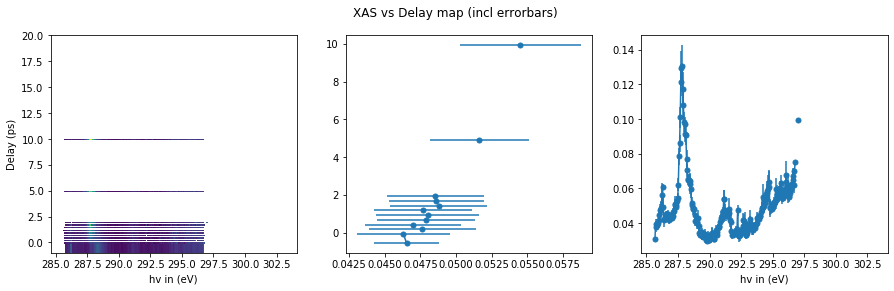

Saved file: C:\Users\larue\OneDrive - Chapman University\Research\Projects\X-Ray Femtochemistry\Elettra & Fermi Lightsources\2017\Binned\BT2\XAS_014_014_D50_E50.h5
Total time: 3.2 s


In [14]:
############################
### Getting Things Ready ###
############################

# Check to ensure data loaded
Continue = True
if not load_xas :
    print('XAS data not loaded')
    Continue = False
if not load_delay :
    print('Delay data not loaded')
    Continue = False
if not Continue :
    raise NameError('Check that all required data is loaded')
print('Binning XAS data...')

# Start timer
t = time.time()

####################
### Bin XAS Data ###
####################

### XAS Binning ###
# Make 2d (delay_mm vs hv_inc) histograms for TFY intensity, i0, num of shots and XAS = TFY / fel_i0
hist_tfy   = np.histogram2d(delay_good, fel_center_good, bins=[delay_bins_edges, xas_bins_edges], weights = xas_int_good)[0]
hist_i0    = np.histogram2d(delay_good, fel_center_good, bins=[delay_bins_edges, xas_bins_edges], weights = fel_i0_good)[0]
hist_shots = np.histogram2d(delay_good, fel_center_good, bins=[delay_bins_edges, xas_bins_edges])[0]
hist_xas   = np.histogram2d(delay_good, fel_center_good, bins=[delay_bins_edges, xas_bins_edges], weights = xas_int_good/fel_i0_good)[0]

# Get the standard deviation for each bin in the above 2d histograms
std_tfy_a = scipy.stats.binned_statistic_2d(delay_good, fel_center_good, xas_int_good, np.std, bins=[delay_bins_edges, xas_bins_edges])
std_i0_a  = scipy.stats.binned_statistic_2d(delay_good, fel_center_good, fel_i0_good, np.std, bins=[delay_bins_edges, xas_bins_edges])
std_xas_a = scipy.stats.binned_statistic_2d(delay_good, fel_center_good, xas_int_good/fel_i0_good, np.std, bins=[delay_bins_edges, xas_bins_edges])

std_tfy   = std_tfy_a.statistic
std_i0    = std_i0_a.statistic
std_xas   = std_xas_a.statistic

# Calculate the standard error for each bin in the above 2d histograms
hist_tfy_err = std_tfy / np.sqrt(hist_shots)
hist_i0_err  = std_i0 / np.sqrt(hist_shots)
hist_xas_err = std_xas / np.sqrt(hist_shots)

# Normalize the 2d histograms by number of shots in each bin
XAS_2dmatrix   = hist_xas / hist_shots
TFY_2dmatrix   = hist_tfy / hist_shots
fel_i0_2dmatrix    = hist_i0  / hist_shots

# Rename shots histogram and error histograms (just for consistency)
Shots_2dmatrix = hist_shots

XAS_2dmatrix_err   = hist_xas_err
TFY_2dmatrix_err   = hist_tfy_err
fel_i0_2dmatrix_err    = hist_i0_err

# Calculate XAS intensity as TFY divided by fel_i0 after binning (v2)
XAS_2dmatrix_v2   = hist_tfy/hist_i0

# Get projections onto hv and delay axis
XAS_hv_all     = np.nansum(XAS_2dmatrix, axis = 0) / np.sum(~np.isnan(XAS_2dmatrix), axis = 0)
XAS_delay_all  = np.nansum(XAS_2dmatrix, axis = 1) / np.sum(~np.isnan(XAS_2dmatrix), axis = 1)
    
XAS_hv_all_err    = np.nansum(XAS_2dmatrix_err, axis = 0) / np.sum(~np.isnan(XAS_2dmatrix_err), axis = 0)
XAS_delay_all_err = np.nansum(XAS_2dmatrix_err, axis = 1) / np.sum(~np.isnan(XAS_2dmatrix_err), axis = 1)

#######################
### Display Results ###
#######################

plt.figure(figsize = [15, 4])
plt.subplot(131)
X,Y = np.meshgrid(xas_bins_edges, delay_bins_edges*1e-3)
plt.pcolor(X, Y, XAS_2dmatrix)
plt.xlabel('hv in (eV)')
plt.ylabel('Delay (ps)')

plt.subplot(132)
plt.errorbar(XAS_delay_all, delay_bins*1e-3, xerr = XAS_delay_all_err, markersize = 5, marker = 'o', ls = '-')

plt.subplot(133)
plt.errorbar(xas_bins, XAS_hv_all, yerr = XAS_hv_all_err, markersize = 5, marker = 'o', ls = '-')
plt.xlim([np.min(xas_bins_edges), np.max(xas_bins_edges)])
plt.xlabel('hv in (eV)')

plt.suptitle('XAS vs Delay map (incl errorbars)')
plt.show()

##############################
### Save Data & Parameters ###
##############################
    
# Define the filename for saved data
run_s_str = '%03d'%(runs[0])
run_e_str = '%03d'%(runs[-1])
save_file = os.path.abspath('../../Binned/BT'+str(BT)+'/XAS'+'_'+run_s_str+'_'+run_e_str+'_D'+str(int(delta*1000))+'_E'+str(int(xas_bins_width*1000))+'.h5')

# Open file (if exists), else create file
fh5 = h5py.File(save_file, 'a') 

# Runs
if 'runs' in fh5: del fh5['runs']
dataSet = fh5.create_dataset('runs', data = runs, dtype = np.int32)
# TimeZero
if 'TimeZero' in fh5: del fh5['TimeZero']
dataSet = fh5.create_dataset('TimeZero', data = TimeZero, dtype = np.float32)

# XAS source
if 'XAS_source' in fh5: del fh5['XAS_source']
dataSet = fh5.create_dataset('XAS_source', data = np.string_(xas_source), dtype="S10")

### Filter Settings
# filter_i0
if 'FilterSettings/filter_fel_i0' in fh5: del fh5['FilterSettings/filter_fel_i0']
dataSet = fh5.create_dataset('FilterSettings/filter_fel_i0', data = filter_fel_i0, dtype = 'u1')
# fel_i0_thr_low
if 'FilterSettings/fel_i0_thr_low' in fh5: del fh5['FilterSettings/fel_i0_thr_low']
dataSet = fh5.create_dataset('FilterSettings/fel_i0_thr_low', data = fel_i0_thr_low, dtype = np.float32)
# fel_i0_thr_hi
if 'FilterSettings/fel_i0_thr_hi' in fh5: del fh5['FilterSettings/fel_i0_thr_hi']
dataSet = fh5.create_dataset('FilterSettings/fel_i0_thr_hi', data = fel_i0_thr_hi, dtype = np.float32)

# filter_fel_width
if 'FilterSettings/filter_fel_width' in fh5: del fh5['FilterSettings/filter_fel_width']
dataSet = fh5.create_dataset('FilterSettings/filter_fel_width', data = filter_fel_width, dtype = 'u1')
# width_thr_low
if 'FilterSettings/fel_width_thr_low' in fh5: del fh5['FilterSettings/fel_width_thr_low']
dataSet = fh5.create_dataset('FilterSettings/fel_width_thr_low', data = fel_width_thr_low, dtype = np.float32)
# fel_i0_thr_hi
if 'FilterSettings/fel_width_thr_hi' in fh5: del fh5['FilterSettings/fel_width_thr_hi']
dataSet = fh5.create_dataset('FilterSettings/fel_width_thr_hi', data = fel_width_thr_hi, dtype = np.float32)

### Bin Settings
# XAS xas_bins_type
if 'BinSettings/xas_bins_type' in fh5: del fh5['BinSettings/xas_bins_type']
dataSet = fh5.create_dataset('BinSettings/xas_bins_type', data = np.string_(xas_bins_type), dtype="S10")
if xas_bins_type == 'auto' :
    # xas_bins_width
    if 'BinSettings/xas_bins_width' in fh5: del fh5['BinSettings/xas_bins_width']
    dataSet = fh5.create_dataset('BinSettings/xas_bins_width', data = xas_bins_width, dtype = np.float32)
if xas_bins_type == 'manual' :
    # xas_bins_edges
    if 'BinSettings/xas_bins_edges' in fh5: del fh5['BinSettings/xas_bins_edges']
    dataSet = fh5.create_dataset('BinSettings/xas_bins_edges', data = xas_bins_edges, dtype = np.float32)
    
# Delay Bin Type
if 'BinSettings/delay_bins_type' in fh5: del fh5['BinSettings/delay_bins_type']
dataSet = fh5.create_dataset('BinSettings/delay_bins_type', data = np.string_(delay_bins_type), dtype="S10")
if delay_bins_type == 'manual' :
    # delay_bins_edges_unit
    if 'BinSettings/delay_bins_unit' in fh5: del fh5['BinSettings/delay_bins_unit']
    dataSet = fh5.create_dataset('BinSettings/delay_bins_unit', data = np.string_(delay_bins_unit), dtype="S10")
    # delay_bins_edges
    if 'BinSettings/delay_bins_edges' in fh5: del fh5['BinSettings/delay_bins_edges']
    dataSet = fh5.create_dataset('BinSettings/delay_bins_edges', data = delay_bins_edges, dtype = np.float32)

### Binned Data

# Incident photon energy axis
if 'BinnedData/xas_bins' in fh5: del fh5['BinnedData/xas_bins']
dataSet = fh5.create_dataset('BinnedData/xas_bins', data = xas_bins, dtype = np.float32)

# Delay axis in fs
if 'BinnedData/delay_bins' in fh5: del fh5['BinnedData/delay_bins']
dataSet = fh5.create_dataset('BinnedData/delay_bins', data = delay_bins, dtype = np.float32)

# 2D data
# XAS intensity 2d matrix
if 'BinnedData/XAS_2dmatrix' in fh5: del fh5['BinnedData/XAS_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/XAS_2dmatrix', data = XAS_2dmatrix, dtype = np.float32)
# XAS intensity 2d matrix (v2 - calculated as hist_tfy/hist_i0)
if 'BinnedData/XAS_2dmatrix_v2' in fh5: del fh5['BinnedData/XAS_2dmatrix_v2']
dataSet = fh5.create_dataset('BinnedData/XAS_2dmatrix_v2', data = XAS_2dmatrix_v2, dtype = np.float32)
# Shots 2d matrix
if 'BinnedData/Shots_2dmatrix' in fh5: del fh5['BinnedData/Shots_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/Shots_2dmatrix', data = Shots_2dmatrix, dtype = np.float32)
# fel_i0 2d matrix (I0 intensity per shot)
if 'BinnedData/fel_i0_2dmatrix' in fh5: del fh5['BinnedData/fel_i0_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/fel_i0_2dmatrix', data = fel_i0_2dmatrix, dtype = np.float32)
# TFY 2d matrix (XAS detector intensity per shot - not normalized by fel_i0)
if 'BinnedData/TFY_2dmatrix' in fh5: del fh5['BinnedData/TFY_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/TFY_2dmatrix', data = TFY_2dmatrix, dtype = np.float32)

# ERRORS 2D data
# XAS intensity 2d matrix
if 'BinnedData/XAS_2dmatrix_err' in fh5: del fh5['BinnedData/XAS_2dmatrix_err']
dataSet = fh5.create_dataset('BinnedData/XAS_2dmatrix_err', data = XAS_2dmatrix_err, dtype = np.float32)
# fel_i0 2d matrix
if 'BinnedData/fel_i0_2dmatrix_err' in fh5: del fh5['BinnedData/fel_i0_2dmatrix_err']
dataSet = fh5.create_dataset('BinnedData/fel_i0_2dmatrix_err', data = fel_i0_2dmatrix_err, dtype = np.float32)
# TFY 2d matrix (XAS detector intensity - not normalized by fel_i0 nor by number of shots)
if 'BinnedData/TFY_2dmatrix_err' in fh5: del fh5['BinnedData/TFY_2dmatrix_err']
dataSet = fh5.create_dataset('BinnedData/TFY_2dmatrix_err', data = TFY_2dmatrix_err, dtype = np.float32)

# PROJECTIONS
# XAS spectrum
if 'BinnedData/XAS_hv_all' in fh5: del fh5['BinnedData/XAS_hv_all']
dataSet = fh5.create_dataset('BinnedData/XAS_hv_all', data = XAS_hv_all, dtype = np.float32)
# Delay trace
if 'BinnedData/XAS_delay_all' in fh5: del fh5['BinnedData/XAS_delay_all']
dataSet = fh5.create_dataset('BinnedData/XAS_delay_all', data = XAS_delay_all, dtype = np.float32)

# ERRORS PROJECTIONS 
# XAS spectrum
if 'BinnedData/XAS_hv_all_err' in fh5: del fh5['BinnedData/XAS_hv_all_err']
dataSet = fh5.create_dataset('BinnedData/XAS_hv_all_err', data = XAS_hv_all_err, dtype = np.float32)
# Delay trace
if 'BinnedData/XAS_delay_all_err' in fh5: del fh5['BinnedData/XAS_delay_all_err']
dataSet = fh5.create_dataset('BinnedData/XAS_delay_all_err', data = XAS_delay_all_err, dtype = np.float32)

fh5.close() # Close the file

print('Saved file: '+save_file)
print('Total time: '+str(round(time.time() - t,1))+' s')

# Bin XES

In [14]:
############################
### Getting Things Ready ###
############################

# Check to ensure data loaded
Continue = True
if not load_xes :
    print('XES data not loaded')
    Continue = False
if not Continue :
    raise NameError('Check that all required data is loaded')
print('Binning XES data...')

# Start timer
t = time.time()

####################
### Bin XES Data ###
####################

xes_shots = np.histogram2d(delay_good, fel_center_good, bins=[delay_bins_edges, xas_bins_edges])[0]

# Rebin the emission energy axis (still in pixels here)
xes_spec_length_red = int(np.floor(xes_spec_length/xes_reduction))
end = int(xes_reduction * xes_spec_length_red)
xes_x       = np.arange(xes_spec_length)
xes_x_rebin = np.sum(np.reshape(xes_x[:end], (-1, xes_reduction)), axis = 1) / xes_reduction

# Create matrix to bin xes spectra into
xes_spec_3dmatrix = np.zeros((len(delay_bins), len(xas_bins), xes_spec_length_red))

# Split up the complete xes spectra array into single spectra
xes_spec_good_split = np.split(xes_spec_good, len(fel_bunchid_good))

# Get bin indices for delay and photon energy axis
delay_good_idx     = np.digitize(delay_good, delay_bins_edges, right = True) - 1
fel_center_good_idx = np.digitize(fel_center_good, xas_bins_edges, right = True) - 1

# Loop over shots
for i in np.arange(len(xes_spec_good_split)) :
    # Rebin xes spectra intensity
    xes_spec_rebin = np.sum(np.reshape(xes_spec_good_split[i][:end], (-1, xes_reduction)), axis = 1) / xes_reduction
    xes_spec_rebin = xes_spec_rebin / xes_shots[delay_good_idx[i], fel_center_good_idx[i]]
    # Sum up the spectra for each delay and photon energy bin
    xes_spec_3dmatrix[delay_good_idx[i], fel_center_good_idx[i], :] = xes_spec_3dmatrix[delay_good_idx[i], fel_center_good_idx[i], :] + xes_spec_rebin

# Tranform pixels into emission energy eV
xes_disp_file = getDisp(BT)
# isp_file = data_path + 'Dispersion/' + xes_disp_file
disp_file = '../src/' + xes_disp_file
h5_disp = h5py.File(disp_file, 'r')
p_disp = h5_disp['p_disp'][()]
h5_disp.close()
xes_x_ev = dt.pix2eV(xes_x_rebin, p_disp)

# Get the XES spectrum for all delays and all photon energies
xes_spec_sum_all = np.sum(np.sum(xes_spec_3dmatrix, axis = 0), axis = 0)
# Sum up all photon energies
xes_specs_delay = np.sum(xes_spec_3dmatrix, axis = 1)
# Sum up all delays
xes_specs_hv = np.sum(xes_spec_3dmatrix, axis = 0)

#######################
### Display Results ###
#######################

plt.figure()
for i in np.arange(len(xas_bins)) :
    plt.plot(xes_x_ev, xes_specs_hv[i], '-o', ms = 3, label = xas_bins[i])
plt.legend(loc = 0)
plt.title('XES for each hv_in bin')
plt.xlim([260, 290])
plt.show()

print('Total time: '+str(round(time.time() - t,1))+' s')

##############################
### Save Data & Parameters ###
##############################
    
# Define the filename for saved data
run_s_str = '%03d'%(runs[0])
run_e_str = '%03d'%(runs[-1])
save_file = os.path.abspath('../../Binned/BT'+str(BT)+'/XES'+'_'+run_s_str+'_'+run_e_str+'_bin_'+str(int(delta*1000))+'.h5')

# Open file (if exists), else create file
fh5 = h5py.File(save_file, 'a') 

# Runs
if 'runs' in fh5: del fh5['runs']
dataSet = fh5.create_dataset('runs', data = runs, dtype = np.int32)
# TimeZero
if 'TimeZero' in fh5: del fh5['TimeZero']
dataSet = fh5.create_dataset('TimeZero', data = TimeZero, dtype = np.float32)

# XAS source
if 'XES_source' in fh5: del fh5['XES_source']
dataSet = fh5.create_dataset('XES_source', data = np.string_(xes_source), dtype="S10")

### Filter Settings
# filter_i0
if 'FilterSettings/filter_fel_i0' in fh5: del fh5['FilterSettings/filter_fel_i0']
dataSet = fh5.create_dataset('FilterSettings/filter_fel_i0', data = filter_fel_i0, dtype = 'u1')
# fel_i0_thr_low
if 'FilterSettings/fel_i0_thr_low' in fh5: del fh5['FilterSettings/fel_i0_thr_low']
dataSet = fh5.create_dataset('FilterSettings/fel_i0_thr_low', data = fel_i0_thr_low, dtype = np.float32)
# fel_i0_thr_hi
if 'FilterSettings/fel_i0_thr_hi' in fh5: del fh5['FilterSettings/fel_i0_thr_hi']
dataSet = fh5.create_dataset('FilterSettings/fel_i0_thr_hi', data = fel_i0_thr_hi, dtype = np.float32)

# filter_fel_width
if 'FilterSettings/filter_fel_width' in fh5: del fh5['FilterSettings/filter_fel_width']
dataSet = fh5.create_dataset('FilterSettings/filter_fel_width', data = filter_fel_width, dtype = 'u1')
# width_thr_low
if 'FilterSettings/fel_width_thr_low' in fh5: del fh5['FilterSettings/fel_width_thr_low']
dataSet = fh5.create_dataset('FilterSettings/fel_width_thr_low', data = fel_width_thr_low, dtype = np.float32)
# fel_i0_thr_hi
if 'FilterSettings/fel_width_thr_hi' in fh5: del fh5['FilterSettings/fel_width_thr_hi']
dataSet = fh5.create_dataset('FilterSettings/fel_width_thr_hi', data = fel_width_thr_hi, dtype = np.float32)

### Bin Settings
# XAS xas_bins_type
if 'BinSettings/xas_bins_type' in fh5: del fh5['BinSettings/xas_bins_type']
dataSet = fh5.create_dataset('BinSettings/xas_bins_type', data = np.string_(xas_bins_type), dtype="S10")
if xas_bins_type == 'auto' :
    # xas_bins_width
    if 'BinSettings/xas_bins_width' in fh5: del fh5['BinSettings/xas_bins_width']
    dataSet = fh5.create_dataset('BinSettings/xas_bins_width', data = xas_bins_width, dtype = np.float32)
if xas_bins_type == 'manual' :
    # xas_bins_edges
    if 'BinSettings/xas_bins_edges' in fh5: del fh5['BinSettings/xas_bins_edges']
    dataSet = fh5.create_dataset('BinSettings/xas_bins_edges', data = xas_bins_edges, dtype = np.float32)
    
# Delay Bin Type
if 'BinSettings/delay_bins_type' in fh5: del fh5['BinSettings/delay_bins_type']
dataSet = fh5.create_dataset('BinSettings/delay_bins_type', data = np.string_(delay_bins_type), dtype="S10")
if delay_bins_type == 'manual' :
    # delay_bins_edges_unit
    if 'BinSettings/delay_bins_unit' in fh5: del fh5['BinSettings/delay_bins_unit']
    dataSet = fh5.create_dataset('BinSettings/delay_bins_unit', data = np.string_(delay_bins_unit), dtype="S10")
    # delay_bins_edges
    if 'BinSettings/delay_bins_edges' in fh5: del fh5['BinSettings/delay_bins_edges']
    dataSet = fh5.create_dataset('BinSettings/delay_bins_edges', data = delay_bins_edges, dtype = np.float32)

### Binned Data

# Incident photon energy axis
if 'BinnedData/xas_bins' in fh5: del fh5['BinnedData/xas_bins']
dataSet = fh5.create_dataset('BinnedData/xas_bins', data = xas_bins, dtype = np.float32)

# Delay axis in fs
if 'BinnedData/delay_bins' in fh5: del fh5['BinnedData/delay_bins']
dataSet = fh5.create_dataset('BinnedData/delay_bins', data = delay_bins, dtype = np.float32)

# XES emission energy axis in pixels
if 'BinnedData/xes_x_pix' in fh5: del fh5['BinnedData/xes_x_pix']
dataSet = fh5.create_dataset('BinnedData/xes_x_pix', data = xes_x_rebin, dtype = np.float32)
# XES emission energy axis in eV
if 'BinnedData/xes_x_ev' in fh5: del fh5['BinnedData/xes_x_ev']
dataSet = fh5.create_dataset('BinnedData/xes_x_ev', data = xes_x_ev, dtype = np.float32)
# 3d dataset (2d matrix in photon energy and delay with full emission spectrum for each bin)
if 'BinnedData/xes_spec_3dmatrix' in fh5: del fh5['BinnedData/xes_spec_3dmatrix']
dataSet = fh5.create_dataset('BinnedData/xes_spec_3dmatrix', data = xes_spec_3dmatrix, dtype = np.float32)
# XES spectrum summed together for all delays and all photon energies
if 'BinnedData/xes_spec_sum_all' in fh5: del fh5['BinnedData/xes_spec_sum_all']
dataSet = fh5.create_dataset('BinnedData/xes_spec_sum_all', data = xes_spec_sum_all, dtype = np.float32)

fh5.close() # Close the file

print('Saved file: '+save_file)
print('Total time: '+str(round(time.time() - t,1))+' s')

XES data not loaded


NameError: Check that all required data is loaded

# Bin Mass Spec

In [16]:
############################
### Getting Things Ready ###
############################

# Check to ensure data loaded
Continue = True
if not load_ms :
    print('Mass spec data not loaded')
    Continue = False
if not Continue :
    raise NameError('Check that all required data is loaded')

print('Binning XAS data...')

t = time.time()

##########################
### Bin Mass Spec Data ###
##########################

ms_tof_hist, ms_tof_bins_edges = np.histogram(ms_tof_good,bins=n_bins)
ms_tof_bins = (ms_tof_bins_edges[1:] + ms_tof_bins_edges[:-1]) / 2
ms_tof_hist = ms_tof_hist / len(ms_counts_good)

plt.plot(ms_tof_bins, ms_tof_hist)
plt.ylabel('Counts / Shot')
plt.xlabel('Time of Flight')
plt.show()

def CopyMSTOF_clicked(b) :
    ToCopy = df(data=ms_tof_hist,index=ms_tof_bins,columns=['Counts/Shot'])
    ToCopy.index.name = 'Time-of-Flight'
    ToCopy.to_clipboard()
CopyMSTOF = widgets.Button(description="Copy plot data",layout=Layout(width='15%'))
CopyMSTOF.on_click(CopyMSTOF_clicked)
display(CopyMSTOF)

if load_xas and load_delay :
    
    ms_counts_hist  = np.histogram2d(delay_good, fel_center_good, bins=[delay_bins_edges, xas_bins_edges], weights = ms_counts_good)[0]
    ms_shots_hist   = np.histogram2d(delay_good, fel_center_good, bins=[delay_bins_edges, xas_bins_edges])[0]
    ms_2dmatrix     = ms_counts_hist / ms_shots_hist

    ms_xas, ms_2dmatrix, ms_delay, ms_errorbars = at.DataTools().TrimData(xas_bins, ms_2dmatrix, delay_bins, ms_2dmatrix, min(xas_bins_edges), max(xas_bins_edges))
    
    X,Y = np.meshgrid(ms_xas, ms_delay)
    plt.pcolor(X, Y, ms_2dmatrix)
    plt.ylabel('Delay')
    plt.xlabel('Energy (eV)')
    plt.show()
    
    def Copy2DMS_clicked(b) :
        ToCopy = df(data=np.transpose(ms_2dmatrix),columns=ms_delay,index=ms_xas)
        ToCopy.index.name = 'Energy (eV)'
        ToCopy.to_clipboard()
    Copy2DMS = widgets.Button(description="Copy plot data",layout=Layout(width='15%'))
    Copy2DMS.on_click(Copy2DMS_clicked)
    display(Copy2DMS)
    
    ms_xas_counts = np.nansum(ms_counts_hist, axis = 0)
    ms_xas_shots = np.nansum(ms_shots_hist, axis = 0)
    ms_xas = ms_xas_counts / ms_xas_shots
    ms_xas_mask = list()
    for idx, i in enumerate(ms_xas) :
        if not math.isnan(i) :
            ms_xas_mask.append(idx)
    plt.plot(xas_bins[ms_xas_mask],ms_xas[ms_xas_mask])
    plt.ylabel('Counts / Shot')
    plt.xlabel('Energy (eV)')
    plt.show()
    
    def CopyMSXAS_clicked(b) :
        ToCopy = df(data=ms_xas,index=xas_bins,columns=['Counts/Shot'])
        ToCopy.index.name = 'Energy (eV)'
        ToCopy.to_clipboard()
    CopyMSXAS = widgets.Button(description="Copy plot data",layout=Layout(width='15%'))
    CopyMSXAS.on_click(CopyMSXAS_clicked)
    display(CopyMSXAS)

    ms_delay_counts = np.nansum(ms_counts_hist, axis = 1)
    ms_delay_shots = np.nansum(ms_shots_hist, axis = 1)
    ms_delay = ms_delay_counts / ms_delay_shots
    ms_delay_mask = list()
    for idx, i in enumerate(ms_delay) :
        if not math.isnan(i) :
            ms_delay_mask.append(idx)
    plt.plot(delay_bins[ms_delay_mask],ms_delay[ms_delay_mask])
    plt.ylabel('Counts / Shot')
    plt.xlabel('Delay (fs)')
    plt.show()
    
    def CopyMSDelay_clicked(b) :
        ToCopy = df(data=ms_delay[DelayMask],index=delay_good[DelayMask],columns=['Counts/Shot'])
        ToCopy.index.name = 'Delay (fs)'
        ToCopy.to_clipboard()
    CopyMSDelay = widgets.Button(description="Copy plot data",layout=Layout(width='15%'))
    CopyMSDelay.on_click(CopyMSDelay_clicked)
    display(CopyMSDelay)

    fel_i0_bins = np.arange(np.nanmin(fel_i0_all), np.nanmax(fel_i0_all), (np.nanmax(fel_i0_all) - np.nanmin(fel_i0_all)) / n_bins)
    ms_fel_i0_counts = np.zeros((len(fel_i0_bins)))
    ms_fel_i0_shots = np.zeros((len(fel_i0_bins)))
    for idx, fel_i0 in enumerate(fel_i0_good) :
        i = (np.abs(fel_i0_bins - fel_i0_good[idx])).argmin()
        ms_fel_i0_counts[i] = ms_fel_i0_counts[i] + ms_counts_good[idx]
        ms_fel_i0_shots[i] = ms_fel_i0_shots[i] + 1
    ms_fel_i0 = ms_fel_i0_counts / ms_fel_i0_shots
    plt.plot(fel_i0_bins,ms_fel_i0)
    plt.ylabel('Counts / Shot')
    plt.xlabel('I0')
    plt.show()
    
    def CopyMSI0_clicked(b) :
        ToCopy = df(data=ms_fel_i0,index=fel_i0_bins,columns=['Counts/Shot'])
        ToCopy.index.name = 'I0'
        ToCopy.to_clipboard()
    CopyMSI0 = widgets.Button(description="Copy plot data",layout=Layout(width='15%'))
    CopyMSI0.on_click(CopyMSI0_clicked)
    display(CopyMSI0)

print('Total time: '+str(round(time.time() - t,1))+' s')

Mass spec data not loaded


NameError: Check that all required data is loaded